In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca
import folium
import shared_utils

from siuba import *
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None) 

import datetime as dt
import time

from calitp import get_engine

engine = get_engine()
connection = engine.connect()

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Join Trips per Stop, Ridership, and ACS data

In [2]:
# start with trips per stop and ridership
stoptrips = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/ahsc_grant/tbl1_trips_perstop.parquet")
stoptrips >> head (5)

,stop_desc,location_type,route_type,stop_name,stop_id,stop_code,calitp_itp_id,geometry,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_sat,n_trips_sun
0,None,None,3,Sunset / Park,8030,8030,182,POINT (-118.26181 34.07778),22.0,30.0,23.0,61.0,61.0
1,None,None,3,Fallbrook / Roscoe,10418,10418,182,POINT (-118.62363 34.21911),15.0,15.0,16.0,25.0,25.0
2,None,None,3,Vanowen / Woodman,15246,15246,182,POINT (-118.43104 34.19407),16.0,15.0,15.0,25.0,25.0
3,None,None,3,Wilshire / Doheny,8417,8417,182,POINT (-118.38985 34.06694),16.0,21.0,16.0,47.0,47.0
4,None,None,3,Fairfax / Rosewood,11986,11986,182,POINT (-118.36159 34.07991),23.0,31.0,27.0,63.0,63.0


In [3]:
ridership = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/ahsc_grant/rider_cleaned_182_2022_03.parquet")
ridership >> head (5)

,calitp_itp_id,stop_id,geometry,sat_ons,sun_ons,weekday_ons
0,182,839,POINT (-118.56218 34.23576),8.0,4.0,61.0
1,182,2786,POINT (-118.36593 33.98405),0.0,0.0,19.0
2,182,6374,POINT (-118.35400 34.24697),0.0,0.0,0.0
3,182,5909,POINT (-118.36770 34.06108),47.0,62.0,855.0
4,182,4511,POINT (-118.15607 33.92645),0.0,0.0,120.0


In [4]:
# join together, keep buses, create total trips per weekday
trips_ridership_joined = (stoptrips
                          >> full_join(_,ridership)
                          >> filter(_.route_type=="3")
                          >> mutate(n_trips_weekday = _.n_trips_ampeak+_.n_trips_midday+_.n_trips_pmpeak)
                         )

trips_ridership_joined >> head (5)

,stop_desc,location_type,route_type,stop_name,stop_id,stop_code,calitp_itp_id,geometry,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_sat,n_trips_sun,sat_ons,sun_ons,weekday_ons,n_trips_weekday
0,None,None,3,Sunset / Park,8030,8030,182,POINT (-118.26181 34.07778),22.0,30.0,23.0,61.0,61.0,149.0,135.0,981.0,75.0
1,None,None,3,Fallbrook / Roscoe,10418,10418,182,POINT (-118.62363 34.21911),15.0,15.0,16.0,25.0,25.0,5.0,6.0,94.0,46.0
2,None,None,3,Vanowen / Woodman,15246,15246,182,POINT (-118.43104 34.19407),16.0,15.0,15.0,25.0,25.0,176.0,118.0,1790.0,46.0
3,None,None,3,Wilshire / Doheny,8417,8417,182,POINT (-118.38985 34.06694),16.0,21.0,16.0,47.0,47.0,55.0,33.0,991.0,53.0
4,None,None,3,Fairfax / Rosewood,11986,11986,182,POINT (-118.36159 34.07991),23.0,31.0,27.0,63.0,63.0,34.0,54.0,1175.0,81.0


In [5]:
# add buffers to stops
trips_ridership_joined = trips_ridership_joined.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

# this replaces our point geometry with polygons
trips_ridership_joined.geometry = trips_ridership_joined.buffer(402.336)

In [6]:
# ACS data
acs_la = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/ahsc_grant/acs_tbl_lacounty.parquet")
acs_la >> head (5)

,ALAND,geometry,geo_id,total_pop,households,not_us_citizen_pop,black_pop,hispanic_pop,inc_extremelylow,inc_verylow,inc_low,pop_determined_poverty_status,poverty,no_car,no_cars
0,3837562,"POLYGON ((-118.58119 34.14318, -118.58099 34.1...",06037137504,2073.0,694.0,23.0,19.0,64.0,30.0,29.0,102.0,2073.0,90.0,12.0,10.0
1,4472196,"POLYGON ((-118.60573 34.14585, -118.60561 34.1...",06037138000,4673.0,1784.0,198.0,325.0,393.0,270.0,124.0,196.0,4673.0,386.0,0.0,19.0
2,1152031,"POLYGON ((-118.53082 34.18024, -118.52952 34.1...",06037139200,5840.0,2172.0,815.0,153.0,1330.0,242.0,315.0,548.0,5840.0,602.0,66.0,108.0
3,957093,"POLYGON ((-118.37899 34.15409, -118.37888 34.1...",06037143200,4210.0,2083.0,167.0,375.0,539.0,303.0,386.0,378.0,4210.0,455.0,172.0,103.0
4,1649223,"POLYGON ((-118.39648 34.15761, -118.39538 34.1...",06037143300,6730.0,3113.0,421.0,477.0,1270.0,436.0,565.0,415.0,6711.0,384.0,62.0,117.0


In [7]:
# join to job data

jobdata=(pd.read_parquet("gs://calitp-analytics-data/data-analyses/ahsc_grant/job_density")
         >> select(_.geo_id,_.jobs_total)
        )

acs_la = (acs_la
          >> left_join(_,jobdata)
         )

In [8]:
# project
acs_la = acs_la.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [9]:
# join to bus buffers - output is stop-buffer level
# each stop is associated with multiple tracts and a tract can be associated with multiple stops
stops_acs_joined = trips_ridership_joined.sjoin(acs_la, how='inner', predicate='intersects')
stops_acs_joined.geo_id.value_counts()

06037207710    145
06037207900    123
06037207301    122
06037532400    115
06037226002    105
              ... 
06037577000      1
06037267902      1
06037430400      1
06037554516      1
06037264103      1
Name: geo_id, Length: 1741, dtype: int64

In [10]:
# roll back up to stop level - sum the counts of people/households in tracts touching the buffer
stops_acs_rollup = (stops_acs_joined
                    >> group_by(_.calitp_itp_id,_.stop_id, _.n_trips_ampeak,_.n_trips_midday,_.n_trips_pmpeak,
                             _.n_trips_sat,_.n_trips_sun,_.sat_ons,_.sun_ons,_.weekday_ons,_.n_trips_weekday)
                    >> summarize(sum_tracts = _.geo_id.count(),
                                 sum_total_pop = _.total_pop.sum(),
                                 sum_households = _.households.sum(),
                                 sum_not_us_citizen_pop = _.not_us_citizen_pop.sum(),
                                 sum_black_pop = _.black_pop.sum(),
                                 sum_hispanic_pop = _.hispanic_pop.sum(),
                                 sum_inc_extremelylow = _.inc_extremelylow.sum(),
                                 sum_inc_verylow = _.inc_verylow.sum(),
                                 sum_inc_low = _.inc_low.sum(),
                                 sum_pop_determined_poverty_status = _.pop_determined_poverty_status.sum(), #denominator for poverty rate
                                 sum_poverty = _.poverty.sum(),
                                 sum_no_car = _.no_car.sum(), #workers without access to car
                                 sum_no_cars = _.no_cars.sum(), #households without car
                                 sum_land_area = _.ALAND.sum(),
                                 sum_jobs=_.jobs_total.sum()
                                )
                    >> ungroup()
                   )

stops_acs_rollup >> head (5)                    

,calitp_itp_id,stop_id,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_sat,n_trips_sun,sat_ons,sun_ons,weekday_ons,n_trips_weekday,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs
0,182,1,13.0,15.0,15.0,44.0,44.0,16.0,24.0,214.0,43.0,1,4031.0,1093.0,696.0,15.0,3766.0,222.0,303.0,197.0,3866.0,338.0,42.0,60.0,3707188,7122.0
1,182,10000002,6.0,7.0,7.0,12.0,12.0,20.0,7.0,102.0,20.0,4,16203.0,4603.0,3061.0,2968.0,9900.0,975.0,1090.0,1146.0,16001.0,2844.0,266.0,364.0,3243477,4193.0
2,182,10033,12.0,15.0,12.0,24.0,24.0,22.0,24.0,205.0,39.0,3,14102.0,4613.0,2455.0,5559.0,7016.0,1357.0,911.0,817.0,13952.0,2738.0,128.0,524.0,2714150,1011.0
3,182,10034,12.0,15.0,12.0,24.0,24.0,7.0,5.0,132.0,39.0,4,18631.0,6567.0,2914.0,8455.0,8467.0,2147.0,1300.0,1201.0,18481.0,3814.0,290.0,945.0,3565703,1809.0
4,182,10035,12.0,15.0,12.0,23.0,23.0,38.0,34.0,371.0,39.0,3,15654.0,5108.0,2848.0,4657.0,9669.0,1324.0,1213.0,1232.0,15469.0,3570.0,207.0,443.0,2568500,1777.0


In [11]:
# derived variables
stops_acs_rollup2 = (stops_acs_rollup
                     >> mutate(pop_density = _.sum_total_pop/_.sum_land_area,
                               job_density = _.sum_jobs/_.sum_land_area,
                               pct_not_us_citizen_pop = _.sum_not_us_citizen_pop/_.sum_total_pop,
                               pct_black_pop = _.sum_black_pop/_.sum_total_pop,
                               pct_hispanic_pop = _.sum_hispanic_pop/_.sum_total_pop,
                               pct_inc_extremelylow = _.sum_inc_extremelylow/_.sum_households,
                               pct_inc_verylow = _.sum_inc_verylow/_.sum_households,
                               pct_inc_low = _.sum_inc_low/_.sum_households,
                               pct_poverty = _.sum_poverty/_.sum_pop_determined_poverty_status,
                               pct_pop_workers_no_car = _.sum_no_car/_.sum_total_pop,
                               pct_hh_no_cars = _.sum_no_cars/_.sum_households
                              ) 
                    )                               

## Correlations with ridership

In [17]:
# import matplotlib.pyplot as plt

corr = stops_acs_rollup2.corr()
corr.style.background_gradient(cmap='coolwarm', vmin=-1., vmax=1.)

,calitp_itp_id,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_sat,n_trips_sun,sat_ons,sun_ons,weekday_ons,n_trips_weekday,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
calitp_itp_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
n_trips_ampeak,nan,1.000000,0.982127,0.988785,0.971146,0.968788,0.561186,0.557820,0.578017,0.995871,0.195768,0.099122,0.217126,0.190167,0.139661,0.054184,0.407989,0.206916,0.124009,0.083622,0.272463,0.308842,0.447438,-0.108485,0.307014,0.257286,0.358750,0.217474,0.132016,0.017395,0.374937,0.100736,-0.090686,0.324478,0.391915,0.467200
n_trips_midday,nan,0.982127,1.000000,0.975912,0.974416,0.972683,0.553572,0.551716,0.568773,0.992634,0.206568,0.105306,0.227853,0.191214,0.125983,0.052484,0.413994,0.213092,0.133037,0.088645,0.274068,0.313552,0.452621,-0.109838,0.302655,0.259236,0.356917,0.214435,0.113843,0.011341,0.370955,0.095928,-0.093162,0.320252,0.394243,0.467031
n_trips_pmpeak,nan,0.988785,0.975912,1.000000,0.966331,0.964693,0.548974,0.545720,0.566658,0.993664,0.194125,0.094009,0.214304,0.188090,0.139304,0.048823,0.407105,0.203808,0.120163,0.078652,0.269260,0.313413,0.449405,-0.105757,0.305053,0.254668,0.357561,0.216520,0.133405,0.014023,0.374367,0.098163,-0.094749,0.323025,0.396874,0.469312
n_trips_sat,nan,0.971146,0.974416,0.966331,1.000000,0.994627,0.565538,0.561931,0.572675,0.976674,0.206786,0.107616,0.223058,0.203624,0.123452,0.062979,0.415989,0.212518,0.128583,0.091466,0.286908,0.329800,0.460381,-0.102951,0.293076,0.269629,0.345556,0.227087,0.112631,0.023707,0.378368,0.100092,-0.090419,0.333702,0.409476,0.479992
n_trips_sun,nan,0.968788,0.972683,0.964693,0.994627,1.000000,0.569330,0.567411,0.577407,0.974763,0.212169,0.110389,0.228420,0.206089,0.123236,0.064567,0.421868,0.218815,0.133039,0.093927,0.288759,0.336276,0.467305,-0.102507,0.299222,0.272357,0.353058,0.227529,0.111188,0.023860,0.378589,0.102094,-0.090884,0.332788,0.413815,0.482942
sat_ons,nan,0.561186,0.553572,0.548974,0.565538,0.569330,1.000000,0.984952,0.974105,0.557846,0.262201,0.186334,0.232160,0.295920,0.083645,0.149450,0.383011,0.293193,0.194885,0.182085,0.318498,0.380259,0.417301,-0.080558,0.134327,0.346525,0.182961,0.268453,0.048952,0.068369,0.300181,0.149894,-0.009773,0.271965,0.384243,0.386527
sun_ons,nan,0.557820,0.551716,0.545720,0.561931,0.567411,0.984952,1.000000,0.962542,0.555050,0.259057,0.185539,0.225497,0.290592,0.084992,0.149133,0.367833,0.289513,0.194001,0.180340,0.308352,0.370424,0.399390,-0.080379,0.123999,0.343636,0.176247,0.260109,0.051044,0.066303,0.289246,0.148436,-0.004694,0.260187,0.369914,0.372137
weekday_ons,nan,0.578017,0.568773,0.566658,0.572675,0.577407,0.974105,0.962542,1.000000,0.574456,0.255970,0.176656,0.210442,0.293450,0.078952,0.157567,0.361992,0.285386,0.186163,0.172105,0.311197,0.354095,0.389843,-0.081315,0.130537,0.337481,0.181863,0.277088,0.046099,0.088368,0.298269,0.169277,0.005196,0.274064,0.365062,0.373117
n_trips_weekday,nan,0.995871,0.992634,0.993664,0.976674,0.974763,0.557846,0.555050,0.574456,1.000000,0.200390,0.100344,0.221470,0.191033,0.135367,0.052157,0.412380,0.209434,0.126835,0.084369,0.273669,0.313918,0.452686,-0.108759,0.306639,0.258715,0.359866,0.217364,0.126587,0.014188,0.375557,0.098748,-0.093455,0.324418,0.396740,0.470645


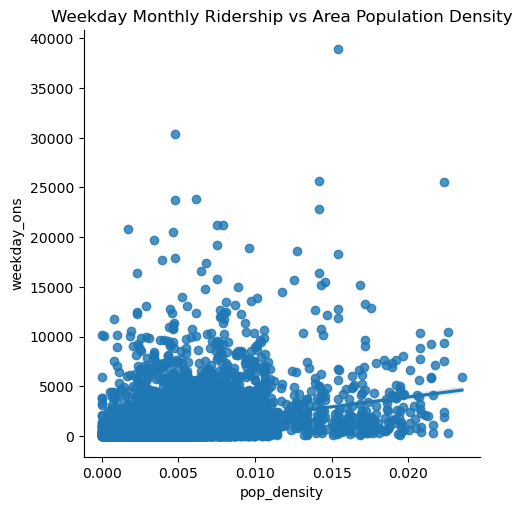

In [13]:
import seaborn as sns

sns.lmplot(x="pop_density",y="weekday_ons", data=stops_acs_rollup2).set(title="Weekday Monthly Ridership vs Area Population Density")

In [18]:
sns.lmplot(x="pct_not_us_citizen_pop",y="weekday_ons", data=stops_acs_rollup2).set(title="Weekday Monthly Ridership vs Non-US-Citizen Population")

In [15]:
sns.lmplot(x="pct_inc_extremelylow",y="weekday_ons", data=stops_acs_rollup2).set(title="Weekday Monthly Ridership vs Extremely Low Income HH")

In [16]:
sns.lmplot(x="pct_hh_no_cars",y="weekday_ons", data=stops_acs_rollup2).set(title="Weekday Monthly Ridership vs No-Car HH")